In [112]:
import pandas as pd
import re

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

def clean_str(list_string):
    clean_string = []
    for string in list_string['article']:
        """Remove html tags from a string"""
        clean = re.compile('<.*?>')
        string =  re.sub(clean, '', string)
        string = re.sub(r"[^A-Za-z]", " ", string).lower()
        clean_string.append(string)
        
    return pd.DataFrame({'article': clean_string, 'target_tags' : list_string['target_tags'], })

def train_doc2vec(tagged_data):
    max_epochs = 100
    vec_size = 100
    alpha = 0.025

    model = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=1,
                    dm =1)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
    #     print('iteration {0}'.format(epoch), model.iter, model.corpus_count)
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("d2v.model")
    
def train_Kmeans(X_train_length, N_CLUSTER = 3):
    vector_train = []

    models = Doc2Vec.load("d2v.model")
    for i in range(X_train_length):
        vector_train.append(models.docvecs[i])
    
    clustering = KMeans(n_clusters=N_CLUSTER).fit(vector_train)
    
    return clustering

# read csv
dataframe = pd.read_csv('data_from_mongo.csv')
dataframe = clean_str(dataframe)

X_train, X_test = train_test_split(dataframe['article'], test_size = 0.3, random_state = 0)
X_train_length = len(X_train)

# preparing doc2vec data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[i]) for i, _d in enumerate(X_train)]

# train
# train_doc2vec(tagged_data)

# train K-Means
clustering = train_Kmeans(X_train_length, N_CLUSTER=10)

In [95]:
# preparing doc2vec data

# X_test = X_test.reset_index()
test_data = [word_tokenize(i) for i in X_test['article']]
new_model = Doc2Vec.load("d2v.model")
vector = new_model.infer_vector(test_data[0])
print(clustering.predict([vector]))

[8]


In [94]:
import pandas as pd
import re
import joblib
import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

class Recommender:
    def __init__(self):
        self.X_train = None
        self.X_test = None
        self.dataframe = pd.read_csv('data_from_mongo.csv')
        
    def __clean_str(self, string):
        """Remove html tags from a string"""
        clean = re.compile('<.*?>')
        string =  re.sub(clean, '', string)
        string = re.sub(r"[^A-Za-z]", " ", string).lower()

        return string
    
    def prepare_data(self):
        # self.dataframe = self.__clean_str(self.dataframe)
        clean_string = [self.__clean_str(i) for i in self.dataframe['article']]
        self.dataframe = pd.DataFrame({'article': clean_string, 'target_tags' : self.dataframe['target_tags'], })

        # split X_train and X_test
        # self.X_train, self.X_test = train_test_split(self.dataframe['article'], test_size = 0.3, random_state = 0)
        self.X_train = self.dataframe['article'].values
        self.X_train_length = len(self.X_train)

        # preparing doc2vec data
        self.tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[i]) for i, _d in enumerate(self.X_train)]
    
    def train_doc2vec(self):
        max_epochs = 100
        vec_size = 100
        alpha = 0.025

        self.model = Doc2Vec(size=vec_size,
                        alpha=alpha, 
                        min_alpha=0.00025,
                        min_count=1,
                        dm =1)

        self.model.build_vocab(self.tagged_data)

        for epoch in range(max_epochs):
            # print('iteration {0}'.format(epoch), model.iter, model.corpus_count)
            self.model.train(self.tagged_data,
                        total_examples=self.model.corpus_count,
                        epochs=self.model.iter)
            # decrease the learning rate
            self.model.alpha -= 0.0002
            # fix the learning rate, no decay
            self.model.min_alpha = self.model.alpha

        self.model.save("d2v.model")
        # pickle.dump(self.model, open("d2v.sav", 'wb'))
        
    def train_Kmeans(self, N_CLUSTER = 3):
        self.vector_train = []

        models = Doc2Vec.load("d2v.model")
        # models = pickle.load(open("d2v.sav", 'rb'))
        for i in range(self.X_train_length):
            self.vector_train.append(models.docvecs[i])

        self.clustering = KMeans(n_clusters=N_CLUSTER).fit(self.vector_train)
        joblib.dump(self.clustering, 'kmeans_alodokter.pkl')

        # return clustering
    
    def load(self):
        self.new_model = Doc2Vec.load("d2v.model")
        self.clustering = joblib.load('kmeans_alodokter.pkl')  
    
    def predict_test_data(self, test):      
        # test_data = [word_tokenize(i) for i in self.X_test]      
        test_data = word_tokenize(test)
        vector = self.new_model.infer_vector(test_data)
        vector1 = self.new_model.infer_vector(test_data)
        print(vector)
        print(vector1)
        
        return self.clustering.predict([vector])
    
if __name__ == '__main__':
    obj = Recommender()
    obj.prepare_data()
    # obj.train_doc2vec()
    # obj.train_Kmeans(N_CLUSTER=4)
    obj.load()
    print(obj.predict_test_data(obj.X_train[2]))
    #print(obj.predict_test_data(obj.X_train[26]))
    # print(obj.clustering.cluster_centers_) # print cluster centroid
    

[-0.48306888  0.13035853  0.43590158  2.107006   -0.7926979   0.8576477
 -0.808782    0.0270013   1.2075244   1.0874237   0.253691   -0.66459495
  0.06180834  1.9078959   1.5264729  -1.5900402   1.1857406  -1.2702866
  2.4824164   0.14093862  0.6108577   0.33235902 -1.3956169  -0.36212692
 -0.83842605 -0.38049066  0.01789856  0.5072904  -0.7315092  -0.40806696
 -0.41664875  0.48886287 -0.33777153 -1.0792862   1.1795188   2.2389255
  0.15157187  0.5568782  -0.7254106  -0.31395945 -3.049837   -0.36447293
  1.7247343   0.20106384  1.1927801  -0.96147543  1.014397    1.3908981
  0.49837577  1.6268764  -2.5519207   1.0483373  -1.255103   -0.6839872
  0.04840311  2.6938336   1.3705009  -3.3723605  -2.5012422  -0.8951014
 -0.07639565 -1.0076905  -2.8601093  -0.4935363  -1.297938    1.4681982
 -2.7368586   1.0260944  -2.754748    0.40794206  0.77435166  0.14741002
  0.38334316  0.45989627  1.0324643   0.14439958  0.5659132   1.273829
  0.1173032   0.36713454 -1.3662722   0.2873249  -0.67508316

In [55]:
# obj.tagged_data[0]
obj.clustering.labels_[0]

0

In [99]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

x1 = obj.new_model.docvecs[2]
x2 = obj.new_model.docvecs[26]
print(x1)
print(norm(x1-x2))
print(cosine_similarity(x1.reshape(1, -1),x2.reshape(1, -1)))

[ -1.3307676    2.162785     2.8449538    3.298031     0.72352177
  -1.305029    -0.16315652  -1.3704907    0.54925126   3.888711
   2.09108     -1.6644938    2.7841492   10.863246     2.5759792
  -4.695674     1.4330909   -4.214667     8.580692     1.9663074
   0.5080572    4.5028563   -3.419003    -2.7817822   -5.0299273
   6.8232675    2.4697363    3.232533    -3.64544     -5.865181
   1.4804049    0.93827856  -0.7097019   -2.3198564    5.850591
   4.907       -1.1134887   -1.890519    -3.5764189   -0.66115
  -2.4648635    0.06469743   0.78742015   0.12676828   0.7780444
  -3.67687      3.817673     1.1924343   -0.43725178   2.0360613
  -5.8975906    0.21545003   0.33807686   0.58101064   2.308533
   7.558346     4.1727085   -7.6290116   -6.689608    -2.2084322
   2.502307    -0.38414806  -8.211552     2.6101432   -5.099205
   1.6900054   -4.102864     3.3613837  -11.149542     1.0412188
   2.5791185   -0.64613086  -0.96697605   4.217946     3.5827396
  -2.0792234   -1.3566953    3.

### Elbow Method

[[0.64346936 0.77845416 0.68020133 ... 0.55348375 0.44919013 0.50081427]
 [0.51372089 0.73094252 0.68842646 ... 0.48379599 0.71429162 0.28530932]
 [0.82713726 0.41760203 0.24925672 ... 0.66248729 0.33539335 0.16465093]
 ...
 [0.52108923 0.56953588 0.41662363 ... 0.74929833 0.17990694 0.12263177]
 [0.61910064 0.74399333 0.75282268 ... 0.42123442 0.13089525 0.8124333 ]
 [0.54656313 0.71526386 0.45900323 ... 0.92873075 0.71612597 0.08274722]]


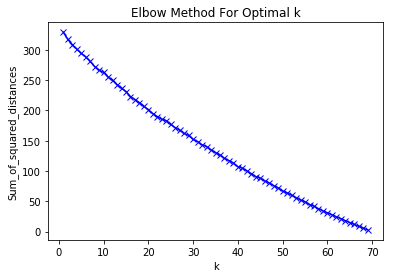

In [51]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

def vector_train(X_train_length):
    vector_train = []

    models = Doc2Vec.load("d2v.model")
    for i in range(X_train_length):
        vector_train.append(models.docvecs[i])
    
    return vector_train


vector_train = vector_train(70)
mms = MinMaxScaler()
mms.fit(vector_train)
data_transformed = mms.transform(vector_train)
print(data_transformed)

Sum_of_squared_distances = []
K = range(1,70)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

[3.4733865]


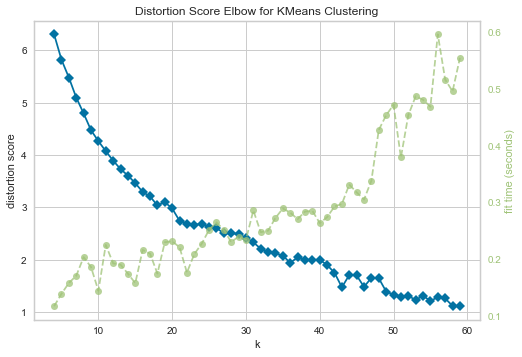

In [75]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np

print(np.array(obj.vector_train).reshape((-1, 1))[0])
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,60))
visualizer.fit(np.array(obj.vector_train).reshape((-1, 1)))    # Fit the data to the visualizer 
visualizer.poof()    # Draw/show/poof the data

In [92]:
print(vector)
print(vector1)

[-0.24690713  1.0686507   0.22987115 -0.82523113 -0.68213254  1.3810478
  0.66148704 -0.9070169  -0.09057514 -0.4878949   0.62929946 -0.72517896
 -0.03206309 -0.31660485 -1.2430723  -0.94525576 -0.6414923   2.479672
 -0.88303256  0.32795283  0.4829619  -3.4126556   1.0799325  -1.8632257
  0.08002006  1.3542616   1.5776837  -1.4611628   0.3927777  -2.2907126
 -1.3572079   0.50743705 -0.59060466 -0.26161572 -0.64521104 -0.38441962
 -0.25168148 -0.55774313 -1.1084664   0.2229649   0.6715598   0.2282579
 -0.1906077   0.5265276   0.98095375 -0.02284571  1.3311971  -0.8873729
  0.42416543 -0.66276026 -1.5308293   2.0576782   0.03824076 -1.6884234
  1.438331   -0.18784967  0.8175427   0.2336255   0.10037988 -1.8496194
 -1.198892   -0.49590346 -1.3439647   0.57083404  0.83122236  1.5316725
 -1.0756226  -3.0908148  -1.0638719   0.8497044  -0.3759177  -0.7050967
  0.02130942  1.2491145   0.30619413 -0.47125202  0.6124414  -0.1092044
 -1.7318518   1.7894133   0.53064495  0.3093063   1.1668295   0

In [30]:
models = Doc2Vec.load("d2v.model")
print(models.docvecs[0])

[ 4.8326554   2.6161776  -0.17319278 -3.495893    0.04940109 -2.2873762
 -3.9242954  -1.5877752   0.20181686  0.5932131   0.05229558  1.775901
 -2.2327702   2.4257126   4.277419   -0.32903296  2.550079   -3.757405
  2.966561   -0.23771442  4.2214584  -9.600871    2.4307458  -0.11367711
  3.901924    1.5537983  -1.9247941  -4.5883617  -7.546621   -1.4431993
 -3.024857    1.9740585   9.847542   -1.6325557   2.6598103   2.557435
  5.8206344   1.6077296  -4.8625264   5.7597976   2.530522    1.3452854
 -0.832309    3.8349032  -2.6490002  -4.424128    0.97110915 -6.227572
 -9.672328   -6.6532235  -0.7964828   1.3273536   1.7293108  -1.2822711
  4.7879467   0.36582345  2.3207188   0.8510329   0.47020385 -7.2574377
  0.29383063  5.6173596  -1.4519687   5.5469794  -0.2326291  -0.94092906
 -0.26083872 -8.99904     0.99617404  1.3950415  -4.68518    -4.3911066
  4.191894    1.7018491   0.6458888  -0.29064333 -0.62601525  1.4531974
  2.8702948  -3.3016965  -4.340639   -3.1038356  -0.53862053  2.17

In [34]:
print(vector_train)

[array([ 4.8326554 ,  2.6161776 , -0.17319278, -3.495893  ,  0.04940109,
       -2.2873762 , -3.9242954 , -1.5877752 ,  0.20181686,  0.5932131 ,
        0.05229558,  1.775901  , -2.2327702 ,  2.4257126 ,  4.277419  ,
       -0.32903296,  2.550079  , -3.757405  ,  2.966561  , -0.23771442,
        4.2214584 , -9.600871  ,  2.4307458 , -0.11367711,  3.901924  ,
        1.5537983 , -1.9247941 , -4.5883617 , -7.546621  , -1.4431993 ,
       -3.024857  ,  1.9740585 ,  9.847542  , -1.6325557 ,  2.6598103 ,
        2.557435  ,  5.8206344 ,  1.6077296 , -4.8625264 ,  5.7597976 ,
        2.530522  ,  1.3452854 , -0.832309  ,  3.8349032 , -2.6490002 ,
       -4.424128  ,  0.97110915, -6.227572  , -9.672328  , -6.6532235 ,
       -0.7964828 ,  1.3273536 ,  1.7293108 , -1.2822711 ,  4.7879467 ,
        0.36582345,  2.3207188 ,  0.8510329 ,  0.47020385, -7.2574377 ,
        0.29383063,  5.6173596 , -1.4519687 ,  5.5469794 , -0.2326291 ,
       -0.94092906, -0.26083872, -8.99904   ,  0.99617404,  1.3

In [41]:
clustering.labels_

array([9, 1, 7, 3, 8, 4, 0, 5, 2, 4, 6, 3, 8, 1, 0, 6, 3, 0, 1, 4, 9, 4,
       6, 8, 7, 2, 8, 9, 8, 1, 1, 7, 8, 0, 4, 4, 5, 7, 1, 2, 4, 2, 4, 5,
       3, 7, 7, 3, 0, 1, 8, 8, 4, 8, 2, 5, 1, 4, 2, 3, 1, 5, 8, 7, 7, 8,
       3, 8, 4, 0], dtype=int32)

In [17]:
print(tagged_data[0])

TaggedDocument(['fungsi', 'kulit', 'dan', 'cara', 'menjaga', 'kesehatannya', 'kulit', 'merupakan', 'salah', 'satu', 'organ', 'tubuh', 'manusia', 'yang', 'sangat', 'penting', 'ada', 'berbagai', 'fungsi', 'kulit', 'termasuk', 'menutupi', 'organ', 'dalam', 'tubuh', 'otot', 'serta', 'sel', 'sel', 'yang', 'ada', 'di', 'dalamnya', 'untuk', 'memaksimalkan', 'fungsi', 'kulit', 'anda', 'perlu', 'menjaga', 'kondisi', 'kesehatannya', 'kulit', 'terdiri', 'dari', 'berbagai', 'komponen', 'termasuk', 'air', 'protein', 'lemak', 'beberapa', 'jenis', 'mineral', 'dan', 'senyawa', 'kimia', 'rata', 'rata', 'berat', 'kulit', 'orang', 'dewasa', 'adalah', 'sekitar', 'kilogram', 'kulit', 'terdiri', 'dari', 'tiga', 'lapisan', 'utama', 'yaitu', 'epidermis', 'dermis', 'dan', 'hipodermis', 'ketiga', 'lapisan', 'itu', 'memiliki', 'peran', 'yang', 'berbeda', 'dalam', 'struktur', 'kulit', 'lima', 'fungsi', 'kulit', 'secara', 'umum', 'ada', 'lima', 'fungsi', 'kulit', 'untuk', 'tubuh', 'yaitu', 'melindungi', 'tubuh', '

In [45]:
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Generate synthetic dataset with 8 blobs
X, y = make_blobs(n_samples=2500, n_features=100, centers=13, shuffle=True, random_state=42)

In [46]:
print(y)

[ 2 12  5 ...  4  8  0]


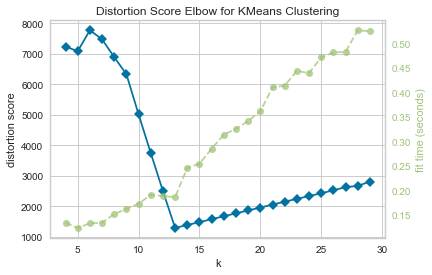

In [48]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,30))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof() 

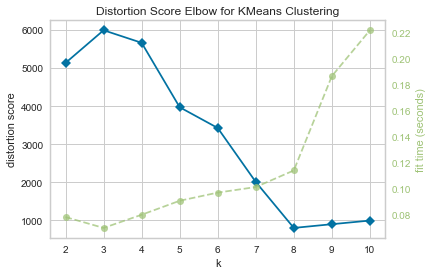

In [35]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X)
model.poof()